# Genetic path planning
* This time we will be taking a look at slightly different application for genetic algorithms.
Turns out that GAs can be used solve a problem of path-planning, a key part of navigation systems in robotics


* Your task will be to complete this code below with mutation, crossover and fitness evaluation functions

## First of all, let's define some configurations

In [ ]:
import numpy as np
import math as ma
import random
import matplotlib.pyplot as plt

In [ ]:
def define_links():
    """
    This function defines the links b/w path points

    Returns
    -------
    [numpy.ndarray]
        [Every path point has a number of allowed connection with other path
        points. Those allowed connections are defined below. During calculation
        of fitness of population if two consecutive path points are connected
        then the fitness of that chromosome increases]
    """

    link = -1 * np.ones((16, 5))

    link[0][0] = 0
    link[0][1] = 1
    link[0][2] = 3
    link[0][3] = 4
    link[1][0] = 1
    link[1][1] = 2
    link[1][2] = 0
    link[2][0] = 2
    link[2][1] = 5
    link[2][2] = 11
    link[2][3] = 1
    link[3][0] = 3
    link[3][1] = 6
    link[3][2] = 8
    link[3][3] = 0
    link[4][0] = 4
    link[4][1] = 5
    link[4][2] = 6
    link[4][3] = 0
    link[5][0] = 5
    link[5][1] = 4
    link[5][2] = 10
    link[5][3] = 2
    link[6][0] = 6
    link[6][1] = 7
    link[6][2] = 3
    link[6][3] = 4
    link[7][0] = 7
    link[7][1] = 9
    link[7][2] = 13
    link[7][3] = 6
    link[8][0] = 8
    link[8][1] = 13
    link[8][2] = 3
    link[9][0] = 9
    link[9][1] = 10
    link[9][2] = 15
    link[9][3] = 7
    link[10][0] = 10
    link[10][1] = 9
    link[10][2] = 11
    link[10][3] = 5
    link[11][0] = 11
    link[11][1] = 12
    link[11][2] = 2
    link[11][3] = 10
    link[12][0] = 12
    link[12][1] = 15
    link[12][2] = 11
    link[13][0] = 13
    link[13][1] = 14
    link[13][2] = 15
    link[13][3] = 7
    link[13][4] = 8
    link[14][0] = 14
    link[14][1] = 15
    link[14][2] = 13
    link[15][0] = 15
    link[15][1] = 9
    link[15][2] = 12
    link[15][3] = 13
    link[15][4] = 14

    return link

## Functions for plots and drawings

In [ ]:
def show_plot(best_chromosome, inf_time=False):
    """
    This function is responsible for displaying plot.

    Parameters
    ----------
    best_chromosome : [numpy.ndarray]
        [numpy array of best chromosome in population of chromosomes]
    """

    plt.figure(num=1)
    plt.clf()
    plt.axis([plt_ax_x_min, plt_ax_x_max, plt_ax_y_min,
        plt_ax_y_max])

    _draw_path_points()
    _draw_obstacles()

    best_path_x = []
    best_path_y = []

    plt.annotate('Start Point', xy=(path_points[int(best_chromosome[0])][0]
        + plt_tolerance, path_points[int(best_chromosome[0])][1]))
    plt.annotate('Goal Point', xy=(path_points[int(best_chromosome[-1])][0]
        + plt_tolerance, path_points[int(best_chromosome[-1])][1]))

    plt.text(x=plt_ax_x_min, y=plt_ax_y_max + plt_tolerance,
        s='Generation:(%s)'%(generations))

    for element in best_chromosome:

        best_path_x.append(path_points[int(element)][0])
        best_path_y.append(path_points[int(element)][1])

    plt.plot(best_path_x, best_path_y, "g-")
    plt.draw()

def _draw_path_points():
    """
    This function is responsible for displaying path points on plot.
    """

    node_x = []
    node_y = []

    for element in path_points:
        node_x.append(element[0])
        node_y.append(element[1])

    plt.plot(node_x, node_y, "ko")


def _draw_obstacles():
    """
    This function is responsible for displaying obstacles on plot.
    """

    obs_1_x = [2.5, 3.5, 3.5, 2.5, 2.5]
    obs_1_y = [9, 9, 12, 12, 9]
    plt.fill(obs_1_x, obs_1_y, "r")

    plt.legend(('Path points', 'Obstacles'), loc='upper right', fontsize='small',
               numpoints=1, markerscale=0.5, labelspacing=1)

    obs_2_x = [3, 4, 4, 3, 3]
    obs_2_y = [6.5, 6.5, 4, 4, 6.5]
    plt.fill(obs_2_x, obs_2_y, "r")

    obs_3_x = [7, 9, 9, 7, 7]
    obs_3_y = [12, 12, 13, 13, 12]
    plt.fill(obs_3_x, obs_3_y, "r")

    obs_4_x = [6.5, 8, 8, 6.5, 6.5]
    obs_4_y = [6, 6, 9.5, 9.5, 6]
    plt.fill(obs_4_x, obs_4_y, "r")

    obs_5_x = [5.7, 8.7, 8.7, 5.7, 5.7]
    obs_5_y = [2, 2, 3, 3, 2]
    plt.fill(obs_5_x, obs_5_y, "r")

    obs_6_x = [11, 12, 12, 11, 11]
    obs_6_y = [8.5, 8.5, 12, 12, 8.5]
    plt.fill(obs_6_x, obs_6_y, "r")

    obs_7_x = [10, 11.5, 11.5, 10, 10]
    obs_7_y = [3.5, 3.5, 5.5, 5.5, 3.5]
    plt.fill(obs_7_x, obs_7_y, "r")

## poplulation

In [ ]:
def _link_distance(link):
    """
    This function is responsible for calculating distance between links

    Parameters
    ----------
    link : [numpy.ndarray]
        [links b/w path points of chromosomes]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of distance b/w links]
    """

    link_dist = np.zeros((np.shape(link)[0], np.shape(link)[1]-1))

    for i in range(np.shape(link)[0]):

        for j in range((np.shape(link)[1])-1):

            if link[i][j] > -0.1 and link[i][j+1] > -0.1:

                link_dist[i][j] = calculate_distance(
                    pt_1=path_points[int(link[i][j])], pt_2=path_points[int(link[i][j+1])])

    return link_dist

In [ ]:
def _link_prob(link_fit):
    """
    This function calculates the probability of links.

    Parameters
    ----------
    link_fit : [numpy.ndarray]
        [numpy array of links connections fitness based on distance]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of links probability based on links fitness]
    """

    link_prob = np.zeros((np.shape(link_fit)[0], np.shape(link_fit)[1]))

    for i in range(np.shape(link_fit)[0]):

        for j in range(np.shape(link_fit)[1]):

            link_prob[i][j] = link_fit[i][j]/np.sum(link_fit[i], keepdims=True)

    return link_prob


In [ ]:
def _create_pop(link_cum_prob):
    """
    This function is responsible for creating chromosome population based on connection
    b/w links.

    Parameters
    ----------
    link_cum_prob : [numpy.ndarray]
        [numpy array of links cumulative probability based on links fitness]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of chromosome population based on connection b/w links]
    """

    pop = np.zeros((pop_max, chr_len))
    pop[:, 0] = start_index
    pop[:, chr_len - 1] = end_index

    link = define_links()

    for k in range(pop_max):
        i = start_index
        j = start_index + 1
        while j < chr_len:
            i = int(i)
            if j > 0 and j < (chr_len - 1):
                random_val = random.random()
                if random_val < link_cum_prob[i][0]:
                    pop[k][j] = link[i][1]
                    i = link[i][1]
                    if _both_equ(i, end_index):
                        while j < (chr_len - 1):
                            pop[k][j+1] = end_index
                            j += 1
                elif random_val < link_cum_prob[i][1]:
                    pop[k][j] = link[i][2]
                    i = link[i][2]
                    if _both_equ(i, end_index):
                        while j < (chr_len - 1):
                            pop[k][j+1] = end_index
                            j += 1
                elif random_val < link_cum_prob[i][2]:
                    pop[k][j] = link[i][3]
                    i = link[i][3]
                    if _both_equ(i, end_index):
                        while j < (chr_len - 1):
                            pop[k][j+1] = end_index
                            j += 1
                elif random_val < link_cum_prob[i][3]:
                    pop[k][j] = link[i][4]
                    i = link[i][4]
                    if _both_equ(i, end_index):
                        while j < (chr_len - 1):
                            pop[k][j+1] = end_index
                            j += 1
            j += 1

    return pop

In [ ]:
def population():
    """
    This function encapsulates the capability to initialize population of chromosomes.

    Returns
    -------
    numpy.ndarray
        Population of chromosomes
    """

    # np.set_printoptions(threshold=np.nan)
    link = define_links()
    link_fit = np.random.rand(len(link))
    link_prob = link_fit / np.sum(link_fit)
    link_cum_prob = np.cumsum(link_prob)
    initial_pop = np.random.choice(link, size=(100, len(link)), p=link_prob)
    return initial_pop

In [ ]:
def _both_equ(element_1, element_2):
    """
    This function is responsible for finding if both elements are equal or not.

    Parameters
    ----------
    element_1 : [Int]
        [First element for comparison]
    element_2 : [Int]
        [Second element for comparison]

    Returns
    -------
    [Bool]
        [True or False based on wether both elements were equal or not]
    """

    return True if int(element_1) == int(element_2) else False

In [ ]:
def calculate_distance(pt_1, pt_2):
    """
    This function encapsulates the capability of calculating distance b/w two points.

    Parameters
    ----------
    pt_1 : [Float]
        [point 1 for calculating distance]
    pt_2 : [Float]
        [point 2 for calculating distance]

    Returns
    -------
    [float]
        [Distance b/w two points]
    """

    return ma.sqrt(ma.pow((pt_1[0]-pt_2[0]), 2)+ma.pow((pt_1[1]-pt_2[1]), 2))

## DNA mutation, and crossover

In [ ]:
def crossover(ranked_pop, chr_best_fit_indx, pop):
    """
    This function is responsible for handling crossover in population of chromosomes.

    Parameters
    ----------
    ranked_pop : [numpy.ndarray]
        [numpy array of chromosome population which will undergo crossover]
    chr_best_fit_indx : [list]
        [Contains list of best fitness indices in chromosome population]
    pop : [numpy.ndarray]
        [numpy array of chromosome population to get best fitness chromosomes
         from last population]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of chromosome population undergone crossover]
    """

    crossover_pop = np.zeros((pop_max, chr_len))

    crossover_pop[0, :] = pop[chr_best_fit_indx[0], :]
    crossover_pop[1, :] = pop[chr_best_fit_indx[1], :]
    crossover_pop[2, :] = pop[chr_best_fit_indx[2], :]

    itr = 3

    while itr < pop_max / 5:
        a = random.randint(0, len(ranked_pop) - 1)
        b = random.randint(0, len(ranked_pop) - 1)
        partner_a = ranked_pop[a]
        partner_b = ranked_pop[b]
        joining_pt = random.randint(1, chr_len - 2)
        crossover_pop[itr, :joining_pt] = partner_a[:joining_pt]
        crossover_pop[itr+1, :joining_pt] = partner_b[:joining_pt]
        crossover_pop[itr, joining_pt:] = partner_b[joining_pt:]
        crossover_pop[itr+1, joining_pt:] = partner_a[joining_pt:]
        itr += 2

    while itr < pop_max:

        crossover_pop[itr] = ranked_pop[itr]
        itr += 1

    return crossover_pop

In [ ]:
def dna(chr_pop_fitness, ranked_population, chr_best_fitness_index, last_pop):
    """
    This function encapsulates functionality related to dna like crossover
    and mutation.

    Parameters
    ----------
    chr_pop_fitness : [numpy.ndarray]
        [Contains fitness values of chromosome population]
    ranked_population : [numpy.ndarray]
        [Contains numpy array of ranked chromosome population]
    chr_best_fitness_index : [list]
        [Contains list of best fitness indices in chromosome population]
    last_pop : [numpy.ndarray]
        [Contains numpy array of last population]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of chromosome with have gone through random crossover and mutation]
    """
    chromo_crossover_pop = crossover(ranked_population, chr_best_fitness_index, last_pop)
    chromo_crossover_mutated_pop = do_mutation(chromo_crossover_pop)
    return chromo_crossover_mutated_pop

In [ ]:
def do_mutation(pop):
    """
    This function is responsible for handling mutation in population of chromosomes.

    Parameters
    ----------
    pop : [numpy.ndarray]
        [numpy array of chromosome population which will undergo mutation]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of chromosome population undergone mutation]
    """
    # mutated_pop is created as a copy of pop to avoid altering the original data.

    mutated_pop = np.copy(pop)
    itr = 3
    while itr < pop_max:
        for k in range(chr_len):
            c = random.random()
            if c < mutation_rate and k != 0:
                mutated_pop[itr][k] = random.randint(1, npts-2)
        itr += 1
    return mutated_pop

## Fitness

In [ ]:
def chr_best_fit_ind(chr_fit):
    """
    This function is responsible for finding best fitness chromosome indices.

    Parameters
    ----------
    chr_fit : [numpy.ndarray]
        [numpy array of chromosome population fitness]

    Returns
    -------
    [list]
        [list of best fitness chromosome indices]
    """

    temp_chr_fit = np.array(chr_fit, copy=True)

    chr_best_fit_index = []

    while len(chr_best_fit_index) < 3:
        y = np.where(temp_chr_fit == np.max(temp_chr_fit))
        for i in range(len(y[0])):
            chr_best_fit_index.append(y[0][i])
        for i in range(len(y[0])):
            temp_chr_fit[y[0][i]] = 0

    return chr_best_fit_index

In [ ]:
def chr_fit_based_conn(chr_conn):
    """
    This function is responsible for calculating fitness of chromosome population
    based on number of connections b/w path points of an individual chromosome

    Parameters
    ----------
    chr_conn : [numpy.ndarray]
        [numpy array of number of connection b/w path points of an individual chromosome]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of chromosome population fitness based on connections]
    """

    chr_conn_fit = np.zeros((pop_max, 1))

    for i in range(pop_max):
        chr_conn_fit[i][0] = chr_conn[i][0] / (chr_len - 1)
    return chr_conn_fit

In [ ]:
def chr_fit_based_dist(chr_pts_consec_dist):
    """
    This function is responsible for calculating chromosome fitness based on total
    distance of individual chromosome.

    Parameters
    ----------
    chr_pts_consec_dist : [numpy.ndarray]
        [numpy array of individual chromosome total distance]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of individual chromosome fitness based on total distance]
    """

    chr_pop_fit_based_dist = np.zeros((pop_max, 1))
    for i in range(pop_max):
      # For each chromosome i, the fitness is calculated as 10.0 * (1.0 / np.sum(chr_pts_consec_dist[i], keepdims=True)).
      # This formula inversely relates fitness to distance, meaning shorter distances yield higher fitness values.
      # The multiplication by 10 scales the fitness score.
      # Write your code here
        chr_pop_fit_based_dist[i][0] = 10.0 * (1.0 / np.sum(chr_pts_consec_dist[i], keepdims=True))
    return chr_pop_fit_based_dist

In [ ]:
def chr_fit(chr_fit_based_dist, chr_fit_based_conn):
    """
    This function is responsible for calculating fitness of chromosome population
    based on total distance of individual chromosome, and links b/w path points
    of individual chromosome.

    Parameters
    ----------
    chr_fit_based_dist : [numpy.ndarray]
        [numpy array of chromosome fitness based on total distance]
    chr_fit_based_conn : [numpy.ndarray]
        [numpy array of chromosome fitness based on links b/w path
        points of individual chromosome]

    Returns
    -------
    [numpy.ndarray]
        [final fitness of chromosome population]
    """

    chr_fit = np.zeros((pop_max, 1))

    for i in range(pop_max):
        # For each chromosome i, the function calculates the final fitness by summing the values from chr_fit_based_dist and chr_fit_based_conn.
        # Write your code here
        chr_fit[i][0] = chr_fit_based_dist[i][0] + chr_fit_based_conn[i][0]
    return chr_fit

In [ ]:
def chr_conn(chr_pop):
    """
    This function is responsible for finding number of connections b/w path points of
    a individual chromosome.

    Parameters
    ----------
    chr_pop : [numpy.ndarray]
        [Population of chromosomes whose number of connections are to be calculated]

    Returns
    -------
    [numpy.ndarray]
        [numpy array of number of connection b/w path points of an individual chromosome]
    """

    link = define_links()
    chr_conn = np.zeros((pop_max, 1))

    for i in range(pop_max):
      # For each chromosome i, it iterates through each consecutive point j and j+1.
      # Variables a and b represent two consecutive points in the chromosome.
      # An innermost loop that checks if b is a valid connection for a by looking it up in link. If found, chr_conn[i][0] is incremented by 1.
      # Write your code here
        for j in range(chr_len - 1):
            a = chr_pop[i][j]
            b = chr_pop[i][j+1]
            for k in range(5):
                if b == link[int(a)][k]:
                    chr_conn[i][0] += 1
    return chr_conn


In [ ]:
def chr_pts_consecutive_dist(pop):
    """
    This function is responsible for calculating total distance of individual
    chromosome in population of chromosomes.

    Parameters
    ----------
    pop : [numpy.ndarray]
        [Population of chromosomes whose total distance is to be calculated]

    Returns
    -------
    [umpy.ndarray]
        [numpy array of individual chromosome total distance]
    """

    chr_pop_dist = np.zeros((pop_max, chr_len-1))

    for i in range(pop_max):
      # The outer loop iterates through each chromosome i.
      # An inner loop that goes through each consecutive pair of points j and j+1 within the chromosome.
      # For each pair, the function calculate_distance is called to compute the distance between two path points,
      # pt_1 and pt_2, retrieved from path_points using the indices specified in the chromosome.
      # Write your code here
        for j in range(chr_len - 1):
            pt_1 = path_points[int(pop[i][j])]
            pt_2 = path_points[int(pop[i][j+1])]
            chr_pop_dist[i][j] = calculate_distance(pt_1, pt_2)
    return chr_pop_dist

In [ ]:
def fitness(chr_pop):
    """
    This function is responsible for calculating fitness of chromosomes.

    Parameters
    ----------
    chr_pop : [numpy.ndarray]
        [Population of chromosomes whose fitness is to be calculated]

    Returns
    -------
    [numpy.ndarray]
        [(1)Population of chromosomes whose fitness is calculated,
         (2)List of indices of best fitness chromosomes]
    """

    chromo_pts_consec_dist = chr_pts_consecutive_dist(pop=chr_pop)

    chromo_fit_based_dist = chr_fit_based_dist(chr_pts_consec_dist=chromo_pts_consec_dist)

    chromo_conn = chr_conn(chr_pop=chr_pop)

    chromo_fit_based_conn = chr_fit_based_conn(chr_conn=chromo_conn)

    chromo_fit = chr_fit(chr_fit_based_dist=chromo_fit_based_dist,
        chr_fit_based_conn=chromo_fit_based_conn)

    chromo_best_fit_index = chr_best_fit_ind(chr_fit=chromo_fit)

    return chromo_fit, chromo_best_fit_index


## Ranking and multi pooling

In [ ]:
def generate_mating_pool(chr_rank, pop):
    """
    This function is responsible for generating mating pool which will undergo
    crossover and mutation in the next stage.

    Parameters
    ----------
    chr_rank : [numpy.ndarray]
        [ranks of chromosomes based on roulets wheeel selection method]
    pop : [numpy.ndarray]
        [Population of chromosomes from which mating pool will be generated]

    Returns
    -------
    [numpy.ndarray]
        [numpy arrayy of mating pool]
    """

    ranked_pop = np.zeros((1, np.shape(pop)[1]))

    for i in range(pop_max):
      # The outer loop iterates through each chromosome i in the population.
      # An inner loop that runs for chr_rank[i, 0] times, which determines how many copies of chromosome i will be added to the mating pool based on its rank.
      # If ranked_pop has only one row, it initializes ranked_pop with the current chromosome.
      # Otherwise, it appends the current chromosome to ranked_pop using np.vstack.
      # Write your code here
        for j in range(int(chr_rank[i, 0])):
            if np.shape(ranked_pop)[0] == 1:
                ranked_pop[0] = pop[i]
            else:
                ranked_pop = np.vstack((ranked_pop, pop[i]))

    return ranked_pop

In [ ]:
def ranking_based_on_roulet_wheel_selection(chr_cum_prob):
    """
    This function encapsulates the capability of doing ranking of chromosomes
    population based on roulets wheel selection method

    Parameters
    ----------
    chr_cum_prob : [numpy.ndarray]
        [Chromosome cumulative probabilty based on chromosome fitness]

    Returns
    -------
    [numpy.ndarray]
        [ranks of chromosomes based on roulets wheeel selection method]
    """

    rand_array = np.random.rand(pop_max)
    no_of_times_chr_got_choosen = np.zeros((pop_max, 1))
    chr_rank = np.zeros((pop_max, 1))

    for i in range(pop_max):
        for k in range(pop_max):
            if rand_array[i] < chr_cum_prob[k]:
                no_of_times_chr_got_choosen[i, 0] = k
                break
                
    for i in range(pop_max):
        for j in range(pop_max):
            if no_of_times_chr_got_choosen[j, 0] == i:
                chr_rank[i, 0] += 1

    return chr_rank

In [ ]:
def cal_prob(chr_pop_fitness):
    """
    Parameters
    ----------
    chr_pop_fitness : [numpy.ndarray]
        [fitness of chromosome population]

    Returns
    -------
    [numpy.ndarray]
        [Chromosome probabilty based on chromosome fitness]
    """

    chr_prob = np.zeros((pop_max, 1))

    for i in range(pop_max):
      # For each chromosome i,
      # the probability is calculated as the ratio of its fitness score (chr_pop_fitness[i, 0])
      # to the total sum of fitness scores for all chromosomes.
      # This normalization step ensures that the probabilities sum to 1.
      # Write your code here
        chr_prob[i, 0] = chr_pop_fitness[i, 0] / np.sum(chr_pop_fitness, keepdims=True)
    return chr_prob

In [ ]:
def ranking(chr_pop_fitness, pop):
    """
    This function encapsulates the capability of generate ranking of chromosome
    population based on roulet wheel selection method.

    Parameters
    ----------
    chr_pop_fitness : [numpy.ndarray]
        [fitness of chromosome population]
    pop : [numpy.ndarray]
        [Population of chromosomes which will undergo ranking process]

    Returns
    -------
    [numpy.ndarray]
        [Population of ranked chromosomes]
    """

    chromo_prob = cal_prob(chr_pop_fitness=chr_pop_fitness)

    chromo_cum_prob = np.cumsum(chromo_prob, axis=0)

    chromo_rank = ranking_based_on_roulet_wheel_selection(chr_cum_prob=chromo_cum_prob)

    chromo_pop_ranked = generate_mating_pool(chr_rank=chromo_rank, pop=pop)

    return chromo_pop_ranked

## Run the program!

<ipython-input-110-9309526c8277>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  link_prob[i][j] = link_fit[i][j]/np.sum(link_fit[i], keepdims=True)
<ipython-input-123-f98767e4687f>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chr_pop_fit_based_dist[i][0] = 10.0 * \
<ipython-input-125-4a957094a7db>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chr_prob[i, 0] = chr_pop_fitness[i, 0] / \


Best chromosome is: [ 0.  4.  6.  7.  9. 15. 15. 15. 15.]
Best chromosome is: [ 0.  4.  6.  7.  9. 15. 15. 15. 15.]
Best chromosome is: [ 0.  4.  6.  7.  9. 15. 15. 15. 15.]
Best chromosome is: [ 0.  4.  6.  7.  9. 15. 15. 15. 15.]
Best chromosome is: [ 0.  4.  6.  7.  9. 15. 15. 15. 15.]


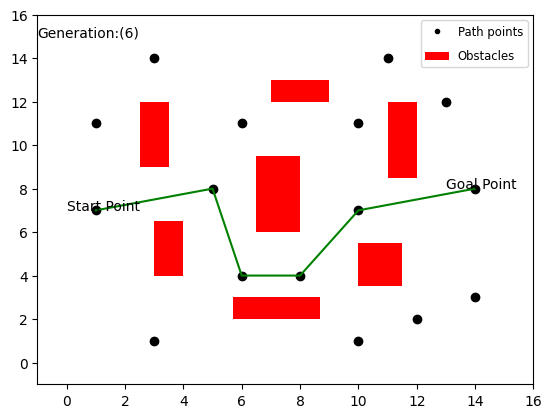

In [ ]:
path_points = [[1, 7], [1, 11], [3, 14], [3, 1], [5, 8], [6, 11], [6, 4], [8, 4], [10, 1], [10, 7], [10, 11], [11, 14], [13, 12], [12, 2], [14, 3], [14, 8]]
npts = len(path_points)
pop_max = 1000
mutation_rate = 0.01
start_index = int(0)
end_index = npts - 1
generations = 1
prev_best_fitness = 0
nobs = 7
nbits = ma.log10(npts) / ma.log10(2)
chr_len = int(((nobs+2)*nbits)/nbits)
stop_criteria = 0
stop_generation = False
img_iter_no = 1
plt_tolerance = -1
plt_ax_x_min = -1.0
plt_ax_x_max = 16.0
plt_ax_y_min = -1
plt_ax_y_max = 16.0
chr_population = population()

chr_pop_fitness, chr_best_fitness_index = fitness(chr_pop=chr_population)

chr_ranked_population = ranking(chr_pop_fitness=chr_pop_fitness, pop=chr_population)

chr_crossover_mutated_population = dna(chr_pop_fitness=chr_pop_fitness,
    ranked_population=chr_ranked_population, chr_best_fitness_index=
    chr_best_fitness_index, last_pop=chr_population)

show_plot(best_chromosome=chr_crossover_mutated_population[0])
stop_generation = False
while not stop_generation:

    prev_best_fit = chr_pop_fitness[chr_best_fitness_index[0], 0]

    chr_pop_fitness, chr_best_fitness_index = fitness(
        chr_pop=chr_crossover_mutated_population)

    chr_ranked_population = ranking(chr_pop_fitness=chr_pop_fitness,
        pop=chr_crossover_mutated_population)

    chr_crossover_mutated_population = dna(chr_pop_fitness=chr_pop_fitness,
        ranked_population=chr_ranked_population, chr_best_fitness_index=
        chr_best_fitness_index, last_pop=chr_crossover_mutated_population)

    if prev_best_fit == chr_pop_fitness[chr_best_fitness_index[0], 0]:
        stop_criteria += 1
    else:
        stop_criteria = 0

    if stop_criteria >= 5:
        stop_generation = True

    print("Best chromosome is:", chr_crossover_mutated_population[chr_best_fitness_index[0]])

    show_plot(best_chromosome=chr_crossover_mutated_population[0])
    generations += 1

show_plot(best_chromosome=chr_crossover_mutated_population[0], inf_time=True)